In [170]:
# Standard Library Imports
import datetime as dt
import os
import pickle
import warnings

# Third-Party Imports
import joblib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from scipy import stats
from scipy.stats import mode, shapiro, ttest_ind, trim_mean
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, f1_score, mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, precision_score, recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer, FunctionTransformer, LabelEncoder, MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from xgboost import XGBRegressor

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

# Local Imports (if any)
#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

# Set warning filters
warnings.filterwarnings('ignore')


In [134]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [135]:
train1 = pd.read_csv("train.csv")
test1 = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")
sample = pd.read_csv("SampleSubmission.csv")
dates = pd.read_csv("dates.csv")
holidays = pd.read_csv("holidays.csv")

In [136]:
stores['cluster'] = stores['cluster'].map(lambda x: 'cluster_' + str(x))  # Convert cluster numbers to cluster names
stores['type'] = stores['type'].map(lambda x: 'store_' + str(x))  # Convert store_type numbers to store_type names
stores['city'] = stores['city'].map(lambda x: 'city_' + str(x))  # Convert city numbers to city names

# Display unique values after conversion
print("Unique clusters:", stores['cluster'].unique())
print("Unique store types:", stores['type'].unique())
print("Unique cities:", stores['city'].unique())

Unique clusters: ['cluster_0' 'cluster_1' 'cluster_2' 'cluster_3' 'cluster_4' 'cluster_5'
 'cluster_6' 'cluster_7' 'cluster_8' 'cluster_9' 'cluster_10' 'cluster_11'
 'cluster_12' 'cluster_13' 'cluster_14' 'cluster_15' 'cluster_16']
Unique store types: ['store_0' 'store_1' 'store_2' 'store_3' 'store_4']
Unique cities: ['city_0' 'city_1' 'city_2' 'city_3' 'city_4' 'city_5' 'city_6' 'city_7'
 'city_8' 'city_9' 'city_10' 'city_11' 'city_12' 'city_13' 'city_14'
 'city_15' 'city_16' 'city_17' 'city_18' 'city_19' 'city_20' 'city_21']


In [137]:
# rename type to store_type to make it more descriptive

stores.rename(columns={'type': 'store_type'}, inplace=True)

In [138]:

# Create new columns for cyclic nature of year
dates["sin(dayofyear)"] = np.sin(2 * np.pi * dates["dayofyear"] / 365)
dates["cos(dayofyear)"] = np.cos(2 * np.pi * dates["dayofyear"] / 365)

# Function to extract datetime
def get_datetime(df):
    df['date_extracted'] = (
        df['year'].add(1900).astype(str) + '-' +
        df['month'].astype(str).str.zfill(2) + '-' +
        df['dayofmonth'].astype(str).str.zfill(2)
    )

get_datetime(dates)

# Display the first few rows of the modified DataFrame
dates.head()


,date,year,month,dayofmonth,dayofweek,dayofyear,weekofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,year_weekofyear,sin(dayofyear),cos(dayofyear),date_extracted
0,12/30/1900,1,1,1,2,1,1,1,True,False,True,False,True,False,101,0.017213,0.999852,1901-01-01
1,12/31/1900,1,1,2,3,2,1,1,False,False,False,False,False,False,101,0.034422,0.999407,1901-01-02
2,1/1/1901,1,1,3,4,3,1,1,False,False,False,False,False,False,101,0.051620,0.998667,1901-01-03
3,1/2/1901,1,1,4,5,4,1,1,False,False,False,False,False,False,101,0.068802,0.997630,1901-01-04
4,1/3/1901,1,1,5,6,5,1,1,False,False,False,False,False,False,101,0.085965,0.996298,1901-01-05


In [139]:
# make each holiday type a string

holidays['type'] = holidays['type'].apply(lambda x: 'holiday_' + str(x))

holidays['type'].value_counts()

type
holiday_0    170
holiday_5     56
holiday_2     38
holiday_1      9
holiday_4      5
holiday_3      3
Name: count, dtype: int64

In [140]:
# rename type to holiday_type to make it more descriptive

holidays.rename( columns={'type': 'holiday_type'}, inplace=True)


In [141]:
def get_is_holiday_column(holidays):
  holidays['holiday_type'] = holidays['holiday_type'].fillna('Workday')

  # create column to show if its a holiday or not (non-holidays are zeros)
  holidays['is_holiday'] = holidays['holiday_type'].apply(
      lambda x: False if x=='Workday'
      else True)

In [142]:
#merging train and test with stores dataset

def merge(df1, df2):
    merged_df = df1.merge(df2, how='left', on='date')

    return merged_df

def merge_stores(df1, df2):
    merged_df = df1.merge(df2, how='left', on='store_id')

    return merged_df

In [143]:
# Merge train with stores
train_merged = merge_stores(train1, stores)

# Merge the result with holidays
train_merged1 = merge(train_merged, holidays)

get_is_holiday_column(train_merged1)

# Merge the result with dates
train = train_merged1

train.head()

,date,store_id,category_id,target,onpromotion,nbr_of_transactions,city,store_type,cluster,holiday_type,is_holiday
0,12/30/1900,store_1,category_24,0.0,0,0,city_0,store_0,cluster_0,holiday_0,True
1,12/30/1900,store_1,category_21,0.0,0,0,city_0,store_0,cluster_0,holiday_0,True
2,12/30/1900,store_1,category_32,0.0,0,0,city_0,store_0,cluster_0,holiday_0,True
3,12/30/1900,store_1,category_18,0.0,0,0,city_0,store_0,cluster_0,holiday_0,True
4,12/30/1900,store_1,category_26,0.0,0,0,city_0,store_0,cluster_0,holiday_0,True


In [144]:
# Assuming your DataFrame is named df
train.drop('nbr_of_transactions', axis=1, inplace=True)


In [145]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064613 entries, 0 to 1064612
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   date          1064613 non-null  object 
 1   store_id      1064613 non-null  object 
 2   category_id   1064613 non-null  object 
 3   target        1064613 non-null  float64
 4   onpromotion   1064613 non-null  int64  
 5   city          1064613 non-null  object 
 6   store_type    1064613 non-null  object 
 7   cluster       1064613 non-null  object 
 8   holiday_type  1064613 non-null  object 
 9   is_holiday    1064613 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 74.1+ MB


In [146]:
# Convert 'date' column to datetime format
train['date'] = pd.to_datetime(train['date'])

In [147]:
train['week_number'] = train['date'].dt.isocalendar().week


In [148]:

agg_df = train.groupby(['store_id', 'date']).agg({'target': 'sum'}).reset_index().sort_values(['store_id', 'date'])


In [149]:
agg_df.head()

,store_id,date,target
0,store_1,1900-12-30,0.000000
1,store_1,1900-12-31,12034.864999
2,store_1,1901-01-01,11700.451400
3,store_1,1901-01-02,10863.582000
4,store_1,1901-01-03,4634.573000


<Figure size 1200x800 with 0 Axes>

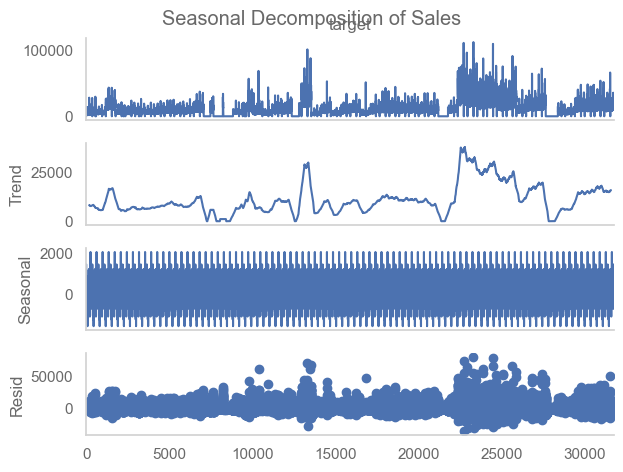

In [150]:

# Perform seasonal decomposition on the 'sales' column
decomposition = seasonal_decompose(agg_df['target'], period=365)

# Plot the seasonal decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Sales')
plt.show()


In [151]:
total_sales_df = agg_df.pivot(index='date', columns=['store_id'], values='target')


In [152]:
total_sales_df.head()

store_id,store_1,store_10,store_11,store_12,store_13,store_14,store_15,store_16,store_17,store_18,...,store_5,store_50,store_51,store_52,store_53,store_54,store_6,store_7,store_8,store_9
date,,,,,,,,,,,,,,,,,,,,,
1900-12-30,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000,0.000000,0.0000,0.000000,...,0.00000,0.0000,0.00000,0.0,0.0,0.000000,0.0000,0.00000,0.00000,0.000000
1900-12-31,12034.864999,9356.284600,22859.23030,8155.76280,7956.95660,9737.74318,9514.322,11158.476800,12431.2191,9461.593199,...,15805.92403,24833.6009,24489.81500,0.0,0.0,6649.813101,20189.5100,23686.85001,23722.49100,20659.096000
1901-01-01,11700.451400,6005.219998,20013.04700,6406.02900,6608.43100,7893.38198,7546.486,8346.570004,8852.0440,7531.542000,...,13725.31180,18498.9467,22570.94520,0.0,0.0,4990.342000,17953.2458,21379.33897,21458.69364,14406.670000
1901-01-02,10863.582000,9258.821980,23012.96295,8341.40500,10942.13901,12655.75800,8121.889,10946.950000,13147.2170,12467.376000,...,14003.54298,30887.2590,29087.15900,0.0,0.0,6368.744000,23950.5760,19886.25600,30477.86600,23875.801049
1901-01-03,4634.573000,9124.824000,26349.69900,8982.48199,7077.37900,7716.54000,7770.217,12603.260000,12746.7490,13859.653000,...,16812.28400,26592.0240,28574.51199,0.0,0.0,10001.927000,26791.2800,20268.38902,29087.65203,24026.703960


In [153]:
# for column in total_sales_df.columns:
#     plt.plot(total_sales_df[column])
#     plt.title(column)
#     plt.show()

In [154]:
missing_data(total_sales_df)

,Total,Percent,Types
store_id,,,
store_1,0,0.000000,float64
store_10,0,0.000000,float64
store_11,0,0.000000,float64
store_12,0,0.000000,float64
store_13,0,0.000000,float64
store_14,0,0.000000,float64
store_15,0,0.000000,float64
store_16,0,0.000000,float64
store_17,0,0.000000,float64


In [155]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [156]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

In [157]:
low_vol_columns

['store_52',
 'store_42',
 'store_22',
 'store_21',
 'store_29',
 'store_32',
 'store_20',
 'store_30',
 'store_35',
 'store_26',
 'store_53',
 'store_10',
 'store_12',
 'store_54',
 'store_14',
 'store_23',
 'store_13',
 'store_15']

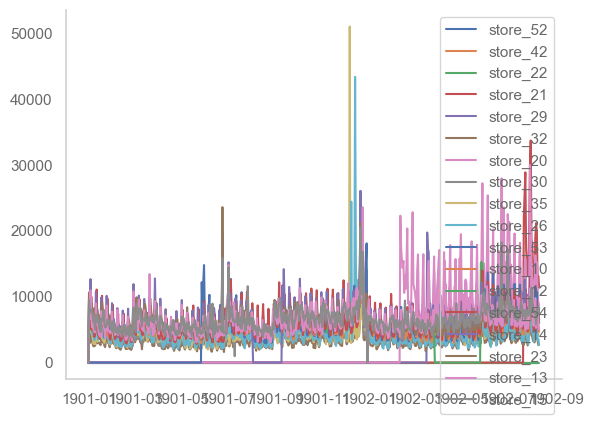

In [158]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

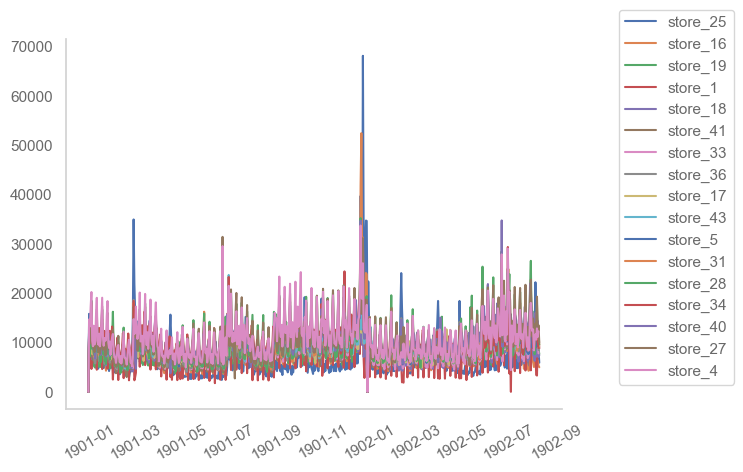

In [159]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

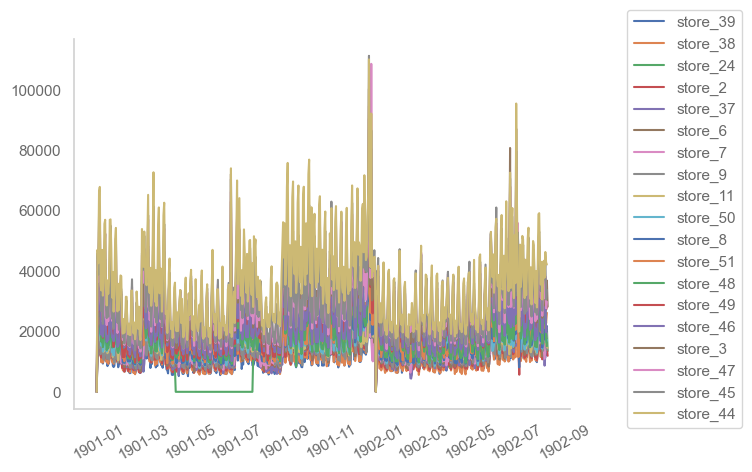

In [160]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

In [161]:
#setting variables
feature = 'store_44'
prediction_days = 30

In [162]:
df = total_sales_df[[feature]].reset_index()
df.head()

store_id,date,store_44
0,1900-12-30,0.0000
1,1900-12-31,47024.6300
2,1901-01-01,42599.8299
3,1901-01-02,66224.0980
4,1901-01-03,67869.9030


In [163]:
min_date = train['date'].min()
max_date = train['date'].max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)


Minimum date: 1900-12-30 00:00:00
Maximum date: 1902-08-10 00:00:00


In [169]:
from datetime import date

forecast_start_dt = date(1902, 7, 1)  # data set ends on (1902, 8, 10)
forecast_start_date = forecast_start_dt.strftime("%Y-%m-%d")
print(forecast_start_date)


1902-07-01


In [171]:
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

11:25:08 - cmdstanpy - INFO - Chain [1] start processing
11:25:09 - cmdstanpy - INFO - Chain [1] done processing


In [173]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [174]:
predicted_df

,ds,yhat,ytrue
0,1902-07-01,36063.251214,61965.245000
1,1902-07-02,46888.792298,40040.634000
2,1902-07-03,43792.015444,19896.671000
3,1902-07-04,32735.394760,20055.140000
4,1902-07-05,31486.816440,48744.499100
5,1902-07-06,33354.095347,34725.333000
6,1902-07-07,31127.196553,38095.963000
7,1902-07-08,36400.819737,51629.620000
8,1902-07-09,47226.360821,50342.467000
9,1902-07-10,44129.583967,37133.795000


In [176]:
100-mape(predicted_df['ytrue'], predicted_df['yhat'])

75.98523950986151

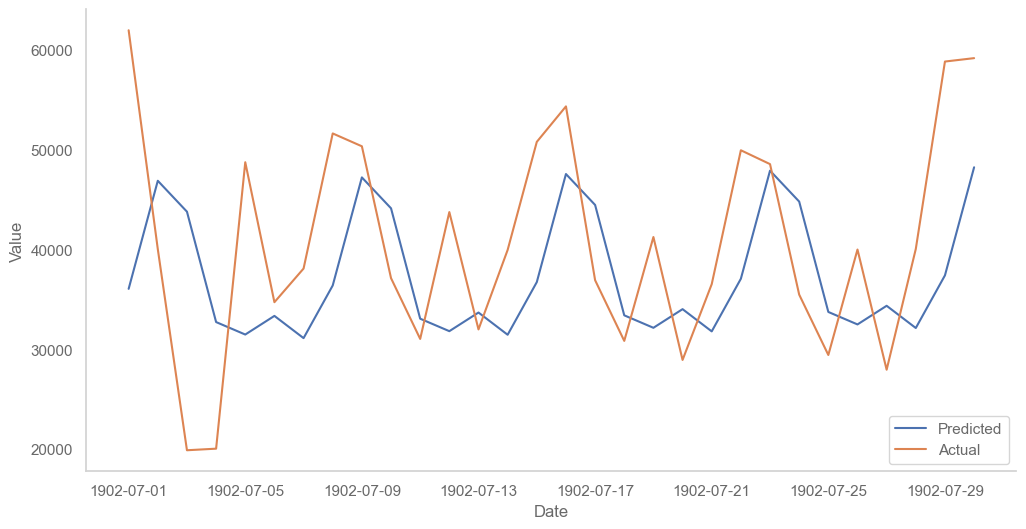

In [182]:
import matplotlib.pyplot as plt

# Assuming predicted_df contains the predicted values and df contains the actual values
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy, on='ds')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted')
plt.plot(predicted_df['ds'], predicted_df['ytrue'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


# CROSS VALIDATION

In [177]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

11:31:06 - cmdstanpy - INFO - Chain [1] start processing
11:31:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]11:31:07 - cmdstanpy - INFO - Chain [1] start processing
11:31:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.61it/s]11:31:08 - cmdstanpy - INFO - Chain [1] start processing
11:31:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.53it/s]11:31:08 - cmdstanpy - INFO - Chain [1] start processing
11:31:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:02,  1.49it/s]11:31:09 - cmdstanpy - INFO - Chain [1] start processing
11:31:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.48it/s]11:31:10 - cmdstanpy - INFO - Chain [1] start processing
11:31:10 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.44it/s]11:31:10 - cmdstanpy - INFO - Chain [1] start processing
11:

In [178]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,2.361943e+08,15368.614666,12137.126616,0.406708,0.336393,0.384499,0.666667
1,4 days,2.428028e+08,15582.130457,12987.811013,0.435499,0.374338,0.415301,0.611111
2,5 days,2.057324e+08,14343.375523,11168.517096,0.345563,0.260511,0.339554,0.722222
3,6 days,1.908691e+08,13815.539630,11406.926249,0.386157,0.318002,0.362516,0.666667
4,7 days,1.739670e+08,13189.654508,11151.629365,0.373586,0.318002,0.362141,0.611111
5,8 days,2.268941e+08,15063.003864,11799.979562,0.437543,0.339199,0.381853,0.666667
6,9 days,2.714953e+08,16477.114937,13394.545830,0.521711,0.418353,0.444933,0.555556
7,10 days,2.880196e+08,16971.139714,12805.261050,0.488008,0.340710,0.410069,0.611111
8,11 days,2.850029e+08,16882.029163,13804.271638,0.515430,0.424397,0.449032,0.555556
9,12 days,2.729701e+08,16521.807786,12429.795387,0.438302,0.354382,0.379359,0.611111


In [179]:
df_p.tail(50)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,2.361943e+08,15368.614666,12137.126616,0.406708,0.336393,0.384499,0.666667
1,4 days,2.428028e+08,15582.130457,12987.811013,0.435499,0.374338,0.415301,0.611111
2,5 days,2.057324e+08,14343.375523,11168.517096,0.345563,0.260511,0.339554,0.722222
3,6 days,1.908691e+08,13815.539630,11406.926249,0.386157,0.318002,0.362516,0.666667
4,7 days,1.739670e+08,13189.654508,11151.629365,0.373586,0.318002,0.362141,0.611111
5,8 days,2.268941e+08,15063.003864,11799.979562,0.437543,0.339199,0.381853,0.666667
6,9 days,2.714953e+08,16477.114937,13394.545830,0.521711,0.418353,0.444933,0.555556
7,10 days,2.880196e+08,16971.139714,12805.261050,0.488008,0.340710,0.410069,0.611111
8,11 days,2.850029e+08,16882.029163,13804.271638,0.515430,0.424397,0.449032,0.555556
9,12 days,2.729701e+08,16521.807786,12429.795387,0.438302,0.354382,0.379359,0.611111
